In [14]:
import pandas as pd
import numpy as np
import yfinance as yf

- Filter the data with filter_vol_periods.
- Compute the time-to-threshold using time_to_threshold.
- Extract pre- and post-threshold slices for detailed analysis with extract_pre_post_data.
- Visualize with plot_isolated_periods.

### Inputs

In [15]:
base_value = 20 
threshold = 30

### Functions

In [16]:
def calculate_rolling_volatility(price_series, window=65):
    """
    Calculate the rolling volatility over a specified window.
    
    Parameters:
    - price_series (pd.Series): A series of price data.
    - window (int): The rolling window size in days (default is 65 days).
    
    Returns:
    - rolling_volatility (pd.Series): The rolling volatility as a percentage.
    """
    # Calculate daily returns
    daily_returns = price_series.pct_change()
    
    # Calculate rolling standard deviation of daily returns
    rolling_volatility = daily_returns.rolling(window=window).std() * (252**0.5)  # Annualized volatility
    
    return rolling_volatility

#### 1. Filter Series by Threshold

Purpose: Identify and isolate periods where volatility exceeds a specific threshold starting from a base value or time.
Function Name: filter_vol_periods(series, base_value, threshold)
Inputs: Time series, base value (initial volatility or date), threshold (e.g., 30).
Output: List of isolated periods.

In [17]:
def filter_vol_periods(series, base_value, threshold):
    """
    Filter a time series to identify and isolate periods where the volatility transitions
    from a base value to a threshold, ensuring it drops below the base value before starting a new period.

    Parameters:
    - series (pd.Series): The time series of volatility data.
    - base_value (float): The starting value to track the rise to the threshold.
    - threshold (float): The threshold value to mark the peak of a period.

    Returns:
    - periods_df (pd.DataFrame): A DataFrame summarizing each period with min and max data.
    """
    import pandas as pd

    # Ensure the series is sorted by index
    series = series.sort_index()

    # Initialize variables
    periods = []
    tracking = False
    current_period = []
    peak_reached = False  # Initialize peak_reached

    for date, value in series.items():
        if not tracking and value >= base_value:
            # Start tracking a new period when the base value is crossed
            tracking = True
            current_period = [(date, value)]
        elif tracking:
            current_period.append((date, value))
            if value >= threshold and not peak_reached:
                # Mark the peak
                peak_reached = True

            if peak_reached and value < base_value:
                # End the period once it goes back below the base value
                periods.append(pd.Series(dict(current_period)))
                tracking = False  # Stop tracking this period
                current_period = []  # Reset for the next period
                peak_reached = False  # Reset the peak flag

    # Combine periods into a single DataFrame
    if periods:
        periods_df = pd.concat(periods, axis=1)
        periods_df.columns = [f"Period_{i+1}" for i in range(len(periods))]
    else:
        # If no periods found, return an empty DataFrame
        periods_df = pd.DataFrame()

    return periods_df

### Data

In [18]:
# Download SPX price data from Yahoo Finance
spx_data = yf.download("^GSPC", start="2001-01-01", end="2013-08-01")
spx_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,1320.280029,1320.280029,1276.050049,1283.270020,1283.270020,1129400000
2001-01-03,1283.270020,1347.760010,1274.619995,1347.560059,1347.560059,1880700000
2001-01-04,1347.560059,1350.239990,1329.140015,1333.339966,1333.339966,2131000000
2001-01-05,1333.339966,1334.770020,1294.949951,1298.349976,1298.349976,1430800000
2001-01-08,1298.349976,1298.349976,1276.290039,1295.859985,1295.859985,1115500000
...,...,...,...,...,...,...
2013-07-25,1685.209961,1690.939941,1680.069946,1690.250000,1690.250000,3322500000
2013-07-26,1687.310059,1691.849976,1676.030029,1691.650024,1691.650024,2762770000
2013-07-29,1690.319946,1690.920044,1681.859985,1685.329956,1685.329956,2840520000


In [19]:
# Example usage (if you have SPX price data):
# Assuming 'spx_data' has a 'Close' column with SPX closing prices:
vol_df = calculate_rolling_volatility(spx_data['Close'], window=65) * 100
vol_df

Date
2001-01-02          NaN
2001-01-03          NaN
2001-01-04          NaN
2001-01-05          NaN
2001-01-08          NaN
                ...    
2013-07-25    12.155109
2013-07-26    12.153330
2013-07-29    12.175531
2013-07-30    12.163175
2013-07-31    12.101986
Name: Close, Length: 3163, dtype: float64

### 1. Filter Series by Threshold

In [20]:
isolated_periods = filter_vol_periods(vol_df, base_value=base_value, threshold=threshold)
isolated_periods

,Period_1,Period_2,Period_3
2001-04-05,25.811329,NaN,NaN
2001-04-06,23.909590,NaN,NaN
2001-04-09,23.948095,NaN,NaN
2001-04-10,24.151370,NaN,NaN
2001-04-11,24.151550,NaN,NaN
...,...,...,...
2012-02-02,NaN,NaN,21.521628
2012-02-03,NaN,NaN,21.090027
2012-02-06,NaN,NaN,20.274462
2012-02-07,NaN,NaN,20.066198


### 2. Calculate Time to Threshold

In [21]:
# Function to calculate time to threshold for each period
def time_to_threshold(series, base_value, threshold):
    """
    Calculate the number of days and corresponding dates taken to reach a threshold value from a base value.

    Parameters:
    - series (pd.DataFrame): DataFrame containing time series columns.
    - base_value (float): The base value to start measuring from.
    - threshold (float): The threshold value to measure to.

    Returns:
    - result_df (pd.DataFrame): DataFrame with the number of days and dates for each column.
    """
    results = []
    
    for column in series.columns:
        # Extract the time index and values
        times = series.index
        values = series[column]

        # Find the indices where the base_value and threshold are crossed
        base_indices = np.where(values >= base_value)[0]
        threshold_indices = np.where(values >= threshold)[0]

        if base_indices.size > 0 and threshold_indices.size > 0:
            for base_idx in base_indices:
                # Find the first threshold index after the base index
                threshold_idx = threshold_indices[threshold_indices > base_idx]
                if threshold_idx.size > 0:
                    base_date = times[base_idx]
                    threshold_date = times[threshold_idx[0]]
                    days_diff = (threshold_date - base_date).days
                    results.append({
                        "Period": column,
                        "Base Date": base_date,
                        "Threshold Date": threshold_date,
                        "Days": days_diff
                    })
                    break  # Only keep the first occurrence
        else:
            results.append({
                "Period": column,
                "Base Date": None,
                "Threshold Date": None,
                "Days": None
            })
    
    result_df = pd.DataFrame(results)
    return result_df

## Plot

### 0. Plot data

<Axes: xlabel='Date'>

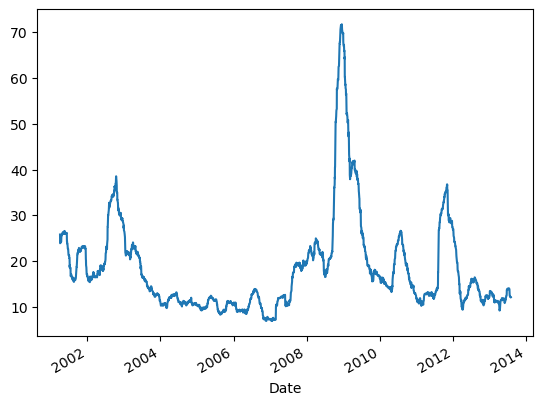

In [22]:
vol_df.plot()

### 1. Plot Filtered Series by Threshold

In [23]:
isolated_periods

,Period_1,Period_2,Period_3
2001-04-05,25.811329,NaN,NaN
2001-04-06,23.909590,NaN,NaN
2001-04-09,23.948095,NaN,NaN
2001-04-10,24.151370,NaN,NaN
2001-04-11,24.151550,NaN,NaN
...,...,...,...
2012-02-02,NaN,NaN,21.521628
2012-02-03,NaN,NaN,21.090027
2012-02-06,NaN,NaN,20.274462
2012-02-07,NaN,NaN,20.066198


<Axes: >

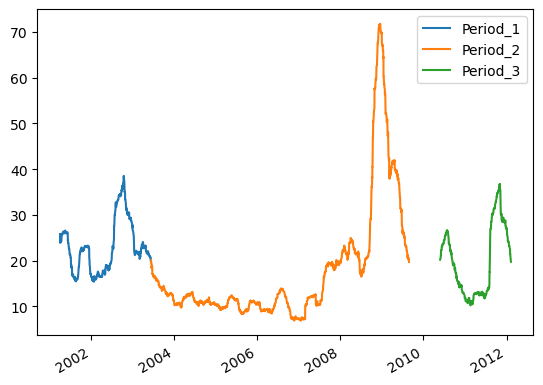

In [24]:
isolated_periods.plot()